In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import r2_score

In [3]:

data = pd.read_csv('Google_Stock_Price_Train.csv',thousands=',')
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500
1,1/4/2012,331.27,333.87,329.08,666.45,5749400
2,1/5/2012,329.83,330.75,326.89,657.21,6590300
3,1/6/2012,328.34,328.77,323.68,648.24,5405900
4,1/9/2012,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,623400
1254,12/27/2016,790.68,797.86,787.66,791.55,789100
1255,12/28/2016,793.70,794.23,783.20,785.05,1153800
1256,12/29/2016,783.33,785.93,778.92,782.79,744300


Text(0, 0.5, 'Stock Volume')

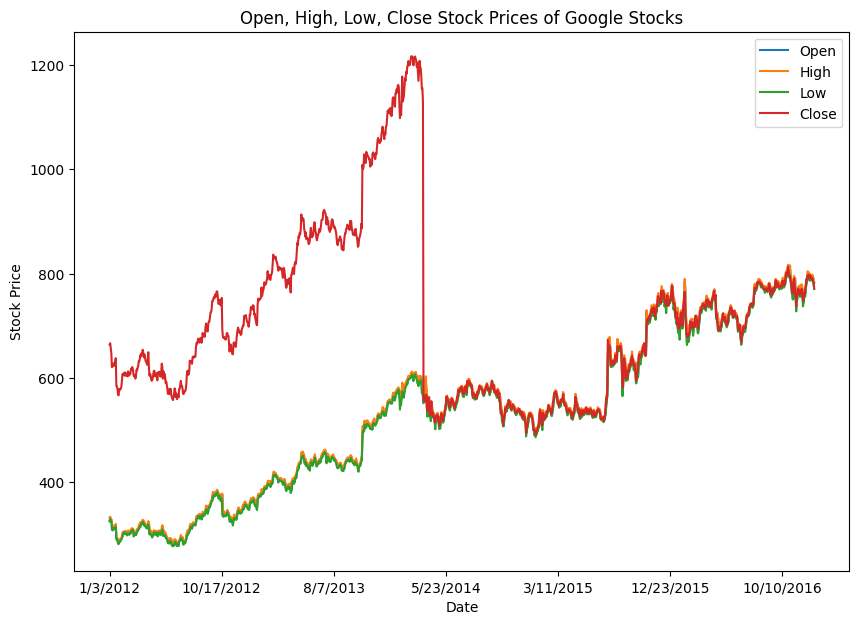

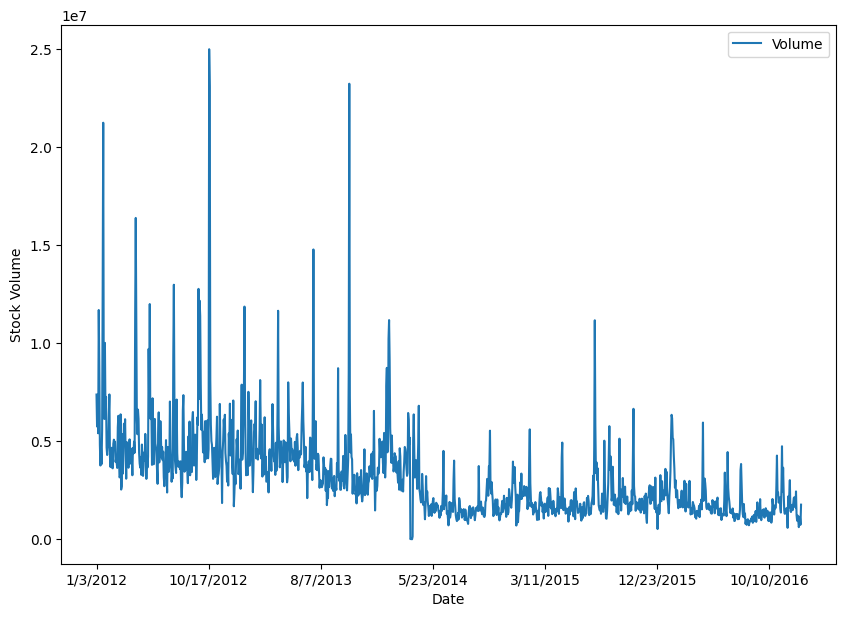

In [ ]:
ax1 = data.plot(x="Date", y=["Open", "High", "Low", "Close"], figsize=(10,7),title='Open, High, Low, Close Stock Prices of Google Stocks')
ax1.set_ylabel("Stock Price")

ax2 = data.plot(x="Date", y=["Volume"],  figsize=(10,7))
ax2.set_ylabel("Stock Volume")

In [ ]:

scaler = MinMaxScaler()
data_without_date = data.drop("Date", axis=1)
scaled_data = pd.DataFrame(scaler.fit_transform(data_without_date))

In [ ]:
scaled_data = scaled_data.drop([0, 2, 3], axis=1)
scaled_data

,1,4
0,0.096401,0.295258
1,0.098344,0.229936
2,0.092517,0.263612
3,0.088819,0.216179
4,0.076718,0.467797
...,...,...
1253,0.955292,0.024650
1254,0.964853,0.031286
1255,0.958074,0.045891
1256,0.942574,0.029491


In [ ]:

def split_seq_multivariate(sequence, n_past, n_future):

    '''
    n_past ==> no of past observations
    n_future ==> no of future observations
    '''
    x = []
    y = []
    for window_start in range(len(sequence)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(sequence):
            break
        # slicing the past and future parts of the window (this indexing is for 2 features vala data only)
        past = sequence[window_start:past_end, :]
        future = sequence[past_end:future_end, -1]
        x.append(past)
        y.append(future)

    return np.array(x), np.array(y)

In [ ]:

n_steps = 60

scaled_data = scaled_data.to_numpy()
scaled_data.shape

(1258, 2)

In [ ]:
x, y = split_seq_multivariate(scaled_data, n_steps, 1)

In [ ]:
x.shape, y.shape

((1198, 60, 2), (1198, 1))

In [ ]:

y = y[:, 0]
y.shape


(1198,)

In [ ]:

x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((958, 60, 2), (240, 60, 2), (958,), (240,))

In [ ]:

model = Sequential()
model.add(LSTM(612, input_shape=(n_steps, 2)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 612)            │     1,505,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        30,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,540,281 (5.88 MB)

 Trainable params: 1,540,281 (5.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=2, validation_data=(x_test, y_test))

Epoch 1/10
30/30 - 18s - 605ms/step - loss: 0.0040 - mae: 0.0360 - val_loss: 0.0048 - val_mae: 0.0380
Epoch 2/10
30/30 - 17s - 575ms/step - loss: 0.0039 - mae: 0.0354 - val_loss: 0.0042 - val_mae: 0.0427
Epoch 3/10
30/30 - 21s - 706ms/step - loss: 0.0038 - mae: 0.0351 - val_loss: 0.0042 - val_mae: 0.0358
Epoch 4/10
30/30 - 20s - 651ms/step - loss: 0.0036 - mae: 0.0327 - val_loss: 0.0045 - val_mae: 0.0358
Epoch 5/10
30/30 - 19s - 631ms/step - loss: 0.0037 - mae: 0.0343 - val_loss: 0.0040 - val_mae: 0.0366
Epoch 6/10
30/30 - 19s - 622ms/step - loss: 0.0036 - mae: 0.0336 - val_loss: 0.0040 - val_mae: 0.0353
Epoch 7/10
30/30 - 21s - 711ms/step - loss: 0.0036 - mae: 0.0334 - val_loss: 0.0039 - val_mae: 0.0402
Epoch 8/10
30/30 - 20s - 650ms/step - loss: 0.0035 - mae: 0.0331 - val_loss: 0.0039 - val_mae: 0.0352
Epoch 9/10
30/30 - 18s - 601ms/step - loss: 0.0034 - mae: 0.0319 - val_loss: 0.0037 - val_mae: 0.0354
Epoch 10/10
30/30 - 20s - 658ms/step - loss: 0.0034 - mae: 0.0318 - val_loss: 0.00

<Axes: >

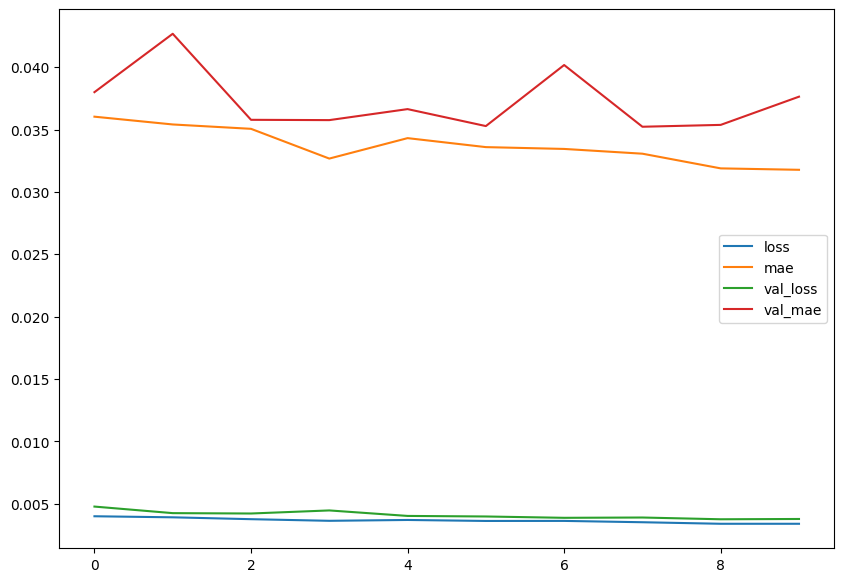

In [ ]:
pd.DataFrame(history.history).plot(figsize=(10,7))

In [ ]:

model.evaluate(x_test, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - loss: 0.0033 - mae: 0.0362


[0.0037724473513662815, 0.03763686120510101]

In [ ]:

predictions = model.predict(x_test)
predictions.shape


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step


(240, 1)

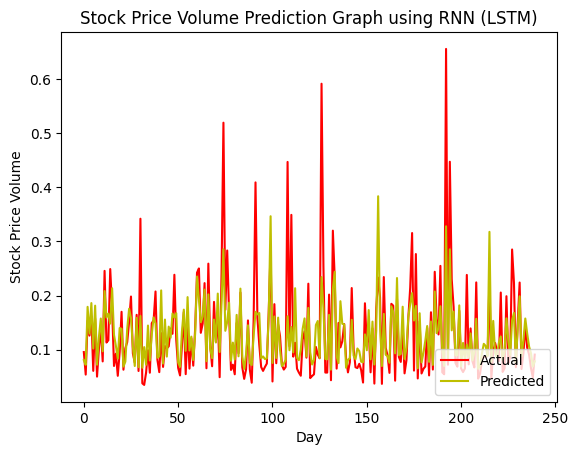

<Figure size 1000x700 with 0 Axes>

In [ ]:
plt.plot(y_test, c = 'r')
plt.plot(predictions, c = 'y')
plt.xlabel('Day')
plt.ylabel('Stock Price Volume')
plt.title('Stock Price Volume Prediction Graph using RNN (LSTM)')
plt.legend(['Actual','Predicted'], loc = 'lower right')
plt.figure(figsize=(10,7))
plt.show()